<a href="https://colab.research.google.com/github/KY-39/platform_udt3/blob/main/%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D0%B7_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA_%D0%B8_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%BF%D1%80%D0%B8_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B5_%D1%81_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%B0%D0%BC%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ООО "Университет Цифровых Технологий платформа 3"

# Синтез библиотек и нейросетей при работе с аудиосигналами - соревнование Kaggle

! Не забудьте создать копию ноутбука и в ней работать, чтобы она у Вас сохранилась с Вашими данными работы и обучения в ячейках: Файл - сохранить копию на Диске.


### Установка и загрузка необходимых модулей

In [1]:
# устанавливаем кроссплатформенную open-source библиотеку для обработки видео- и аудиофайлов ffmpeg
!pip install ffmpeg-python # системная команда начинается с "!", pip-установщик, система подобна Linux
!pip install pydub # требуется для успешной загрузки датасета tensorflow
# устанавливаем свежий Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=59172c4db2fb48728e822d12393e2b0c551630ef3074c40ef7a968dd29a52b10
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


! После установки рекомендуется перезапустить среду выполнения во избежание ошибок запуска ячеек.

In [2]:
#здесь загружаем нужные библиотеки
import ffmpeg # для работы с аудио
#для работы нейронной сети
import tensorflow as tf
import tensorflow_datasets as tfds # для загрузки датасетов tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, ZeroPadding1D, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling1D, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
#для обработки аудио 
import librosa # библиотека обработки аудио
import librosa.display # вывод графиков средствами librosa
import soundfile as sf # для сохранения аудиофайлов
#лля математической обработки данных
import pandas as pd
import numpy as np
#для вызова прямо в среде программирования команд операционной оболочки
import os
# чтобы можно было добавлять цифры (переменные) в путь
import os.path
from scipy.fft import fft, fftfreq # для преобразования Фурье
#для построения графиков и отрисовки
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn # большая библиотека, нам нужно для работы с Либрозой
from sklearn.utils import resample #для перемешивания выборок
import random  # Для генерации случайных выборок из датасета и для фиксации псевдослучайного деления
random.seed(2) #  фиксация псевдослучайного деления

# загружаем модули чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке и модуль воспроизведения аудио
from IPython.display import HTML, Audio 
from google.colab.output import eval_js # для работы с кодом Javascript 
from base64 import b64decode # модуль для кодировки/раскодировки аудиозаписи(64-разрядный код)
from scipy.io.wavfile import read as wav_read # для чтения WAV формата

import scipy # воспользуемся модулями библиотеки для работы со звуковой дорожкой
import io # input-output, для работы с файлами

import h5py as h5 # для работы с файлами h5
import gc # для удаления неиспользуемых данных

from time import sleep, time # для установки временной паузы в сек. и расчёта времени

#import warnings # удаление предупреждений
#warnings.filterwarnings('ignore')

# Распознавание произносимых цифр

#Домашнее задание

##**Задание 1.** 
Загрузите из датасета по ссылке ниже базы произнесённых по-английски цифр - тренировочную и валидационную, а также базу для тестирования. С помощью методов, изученных в занятиях по работе с таблицами Pandas, Анализ и обработка данных, и данном занятии, обработайте датасет и подайте в нейронную сеть, постаравшись добиться максимальной точности распознавания. Для улучшения обучения можно использовать также дополнительные методы, не рассмотренные в занятиях, слои, функции активации, менять параметры оптимизатора Adam и прочие гиперпараметры. Результаты рекомендуется заносить в таблицу для себя, чтобы можно было потом воспроизвести лучший вариант. Предсказание Вашей сети необходимо отправить в виде специального файла с расширением csv, чтобы войти в рейтинговую таблицу соревнования. Ответ можно улучшить и подавать результат несколько раз.

Ссылка на соревнование:

https://www.kaggle.com/t/92d4cbcb7d184582b904726ba95fc93c


Будем использовать датасет Spoken digit из набора Tensorflow, для классификации 10 цифр, произнесённых по-английски.

Бесплатный набор аудиоданных из разговорных цифр. Представляет MNIST для аудио. Простой набор аудио/речевых данных, состоящий из записей произносимых цифр в файлах wav с частотой 8 кГц. Записи обрезаются так, чтобы в начале и в конце была минимальная тишина. 5 говорящих 2500 записей (по 50 каждой цифры на говорящего). Произношение на английском языке.

Содержание датасета:
Набор данных содержится в 3 массивах (train, test, val) и содержит метки категорий цифр. Меток нет только в тестовом наборе, их нужно спрогнозировать нейронной сетью и отослать на соревнование в виде файла csv. 

Ссылка на источник:

https://github.com/Jakobovski/free-spoken-digit-dataset

##Решение

#### Создаём правильную папку для ключа Каггл

In [3]:
!mkdir ~/.kaggle # создаём папку для ключа kaggle в Колабе, она должна быть такой по требованию Каггл

In [4]:
# переходим в папку, теперь это путь по умолчанию
%cd ~/.kaggle

/root/.kaggle


In [5]:
#запускаем - подключаем Google Drive - будем скачивать с него, т.к. намного быстрее
#после запуска переходим по ссылке, которая появится, для идентификации
#копируем оттуда код authorization code и вставляем здесь в окошко
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Устанавливаем ключ Каггл, чтобы участвовать в соревнованиях

Нужно зарегистрироваться на Каггл (https://www.kaggle.com/) и скачать ключ для взаимодействия с API соревновательной системы Каггла. После регистрации, справа появятся Ваши имя и фамилия - ссылка на персональную страницу. Нажмите на них. Когда страница загрузится, справа увидите Account. Нажимаете на надпись, затем прокручиваете страницу вниз, до вкладки API, там нажимаете Create New API Token. 
Ключ - это файл kaggle.json, который скачается после нажатия. Нужно скопировать его в папку Google Drive, предварительно её создав: My Drive/datasets/kaggle/ (из Колаба её адрес, который будем указывать для загрузки, такой: /content/drive/My Drive/datasets/kaggle/).

In [6]:
# нужно зарегистрироваться на Каггл и скачать ключ для взаимодействия с API
# соревновательной системы Каггла kaggle.json. Нужно скопировать его в папку
# Google Drive, предварительно её создав: /content/drive/My Drive/datasets/kaggle/
!cp '/content/drive/My Drive/datasets/kaggle/kaggle.json' '/root/.kaggle/kaggle.json'

In [7]:
!kaggle --version

Kaggle API 1.5.12


In [8]:
!ls

kaggle.json


###Подключаемся к системе соревнований, скачиваем датасет

In [9]:
!kaggle competitions download -c udt-3-audio # скачиваем датасет и тестовые данные

 98% 198M/203M [00:02<00:00, 129MB/s]
100% 203M/203M [00:02<00:00, 78.4MB/s]


### Альтернатива - скачиваем датасет, обрабатываем

In [10]:
!wget http://dataudt.ru/datasets/spoken_digits.zip

--2022-02-26 19:27:05--  http://dataudt.ru/datasets/spoken_digits.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212279885 (202M) [application/zip]
Saving to: ‘spoken_digits.zip’

spoken_digits.zip   100%[===================>] 202.45M  16.7MB/s    in 14s     

2022-02-26 19:27:19 (14.9 MB/s) - ‘spoken_digits.zip’ saved [212279885/212279885]



In [11]:
!ls

kaggle.json  spoken_digits.zip	udt-3-audio.zip


###Разархивируем датасет

In [12]:
# разархивируем данные
import zipfile 
import io
z = zipfile.ZipFile('udt-3-audio.zip', 'r') #загрузили из архива, распаковали
z.extractall()
!ls

 kaggle.json		  spoken_digits.zip   train_sd.npz      val_sd.npz
'sample submission.csv'   test_sd.npz	      udt-3-audio.zip


In [13]:
train = np.load('train_sd.npz')
val = np.load('val_sd.npz')
test = np.load('test_sd.npz')

In [14]:
print(train.files)
print(val.files)
print(test.files)

['X_train_s', 'Y_train_s']
['X_val_s', 'Y_val_s']
['X_test_s']


In [15]:
X_train_s = train['X_train_s']
Y_train_s = train['Y_train_s']

X_val_s = val['X_val_s']
Y_val_s = val['Y_val_s']

X_test_s = test['X_test_s']

In [16]:
mfcc_ = 23 # устанавливаем число мел коэффициентов
sr = 22050 # частота сэмплирования датасета 8268

In [17]:
classes_dict = {
0:'zero',
1:'one',
2:'two',
3:'free',
4:'four',
5:'five',
6:'six',
7:'seven',
8:'eight',
9:'nine'
}

In [18]:
classes = classes_dict.keys()
classes

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Выводим примеры произносимых цифр

In [19]:
for idx in range(len(classes)): #Проходим по классам
    print('играет жанр:', classes_dict[idx])
    label_indexes = np.where(Y_train_s==idx)[0] # Получаем список из индексов положений класса idx в Y_data
    index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
    #Выбираем из x_train композицию нужного класса, прослушиваем:
    display(Audio(X_train_s[index], rate=8268, autoplay=True))
    sleep(2)
    

играет жанр: zero


играет жанр: one


играет жанр: two


играет жанр: free


играет жанр: four


играет жанр: five


играет жанр: six


играет жанр: seven


играет жанр: eight


играет жанр: nine


### Подпрограммы обработки данных

In [20]:
#подпрограмма выделения признаков
def get_features(y, sr, mfcc, shuffle):
    #выделяем признаки
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=mfcc)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    spec_contr = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_flat = librosa.feature.spectral_flatness(y=y) #, sr=sr
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    #chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    #chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    #tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    #tempogram = librosa.feature.tempogram(y=y, sr=sr)
    #fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)

    '''
    print('размерности:')
    print('chroma_stft', chroma_stft.shape)
    print('rmse', rmse.shape)
    print('spec_cent', spec_cent.shape)
    print('spec_bw', spec_bw.shape)
    print('rolloff', rolloff.shape)
    print('zcr', zcr.shape)
    print('mfcc', mfcc.shape)
    print('chroma_cqt', chroma_cqt.shape)
    print('chroma_cens', chroma_cens.shape)
    print('melspec', melspec.shape)
    print('spec_contr', spec_contr.shape)
    print('spec_flat', spec_flat.shape)
    print('poly_features', poly_features.shape)
    print('tonnetz', tonnetz.shape)
    print('tempogram', tempogram.shape)
    print('fourier_tempogram', fourier_tempogram.shape)
    '''
    #добавляем признаки в массив, должна получиться матрица чисел размером (количество файлов) х 
    #(общее количество столбцов в признаках)    
    out = np.concatenate((rmse, spec_cent, spec_bw, rolloff, zcr, chroma_stft, 
                          mfcc, melspec, spec_contr, spec_flat, poly_features 
                          ), axis=0) #chroma_cqt, chroma_cens, tonnetz, tempogram
    out1 = np.mean(out, axis = 1)

    return out1


#делаем подпрограмму
#формируем выборки, входные данные сети это X_train, выходные - Y_train
def get_np_data(X_train_s, Y_train_s, mfcc=mfcc_, shuffle = True):
    X_train, Y_train = [], []
    for X, Y in zip(X_train_s, Y_train_s): # берём соответствующие друг другу данные и метки

        out = get_features(X, sr, mfcc, shuffle = shuffle) # получаем усреднённые аудиоданные
        X_train.append(out)
        Y_train.append(utils.to_categorical(Y, len(classes)))
        print(len(Y_train))

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    if shuffle == True:
        X_train, Y_train = resample(X_train, Y_train, random_state=0) # перемешиваем выборки
    y_train_class = np.argmax(Y_train, axis=1)
    X_train = X_train.astype('float32') # переводим входные данные в тип, понятный нейронной сети - с плавающей точкой, 32 разряда
    Y_train = Y_train.astype('float32')
    y_train_class = y_train_class.astype('float32') 
    print(X_train.shape)
    print(Y_train.shape)

    return X_train, Y_train, y_train_class 

#делаем подпрограмму
#формируем выборки, входные данные сети это X_train, выходные - Y_train
def get_test_np_data(X_train_s, mfcc=mfcc_, shuffle = False):
    X_train = []
    for X in X_train_s: # берём соответствующие друг другу данные и метки

        out = get_features(X, sr, mfcc, shuffle = shuffle) # получаем усреднённые аудиоданные
        X_train.append(out)

    X_train = np.array(X_train)
    X_train = X_train.astype('float32') # переводим входные данные в тип, понятный нейронной сети - с плавающей точкой, 32 разряда
    print(X_train.shape)

    return X_train


### Создаём и нормируем выборки

In [21]:
X_train, Y_train, Y_train_class = get_np_data(X_train_s, Y_train_s, mfcc=mfcc_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [22]:
X_val, Y_val, Y_val_class = get_np_data(X_val_s, Y_val_s, mfcc=mfcc_, shuffle = False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
(125, 178)
(125, 10)


In [23]:
X_test = get_test_np_data(X_test_s, mfcc=mfcc_) # для этих данных, метки удалены, поэтому другая функция

(250, 178)


In [24]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных всех признаков
scaler2 = StandardScaler()
#Номируем X_train, X_test
X_train = scaler2.fit_transform(X_train)
X_val = scaler2.transform(X_val)
X_test = scaler2.transform(X_test)

### Создаём и обучаем нейросеть

In [25]:
gc.collect() # очищаем память от лишнего, чтобы памяти было достаточно для нейросети

model_ms = Sequential() # Создаём свёрточную сеть
model_ms.add(Dense(512, input_shape=X_train.shape[1:], activation="relu")) # Добавляем полносвязный слой из нейронов с relu-активацией
model_ms.add(Dropout(0.1))
model_ms.add(Dense(256, activation="relu"))
model_ms.add(Dropout(0.1))
model_ms.add(Dense(128, activation="relu"))
model_ms.add(Dropout(0.1))
model_ms.add(Dense(64, activation="relu"))
model_ms.add(Dropout(0.1))
model_ms.add(Dense(32, activation="relu"))
model_ms.add(Dense(10, activation="softmax")) # Добавляем полносвязный слой из нейронов с softmax-активацией

model_ms.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"]) # Компилируем модель

print(model_ms.summary()) #Вывод структуры модели

hist_model_ms = model_ms.fit(X_train, Y_train, batch_size=50, epochs=100, validation_data=(X_val, Y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               91648     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/100
43/43 [==============================] - 1s 12ms/step - loss: 1.8447 - accuracy: 0.3906 - val_loss: 0.9138 - val_accuracy: 0.6960
Epoch 2/100
43/43 [==============================] - 0s 7ms/step - loss: 0.8153 - accuracy: 0.7544 - val_loss: 0.4651 - val_accuracy: 0.8400
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.4144 - accuracy: 0.8593 - val_loss: 0.2958 - val_accuracy: 0.9120
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2679 - accuracy: 0.9162 - val_loss: 0.2660 - val_accuracy: 0.8880
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.3381 - accuracy: 0.9445 - val_loss: 0.2837 - val_accuracy: 0.8960
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 0.9567 - val_loss: 0.2620 - val_accuracy: 0.9040
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1820 - accuracy: 0.9576 - val_loss: 0.2403 - val_accuracy: 0.9280
Epoch 8

###Выводим графики точности

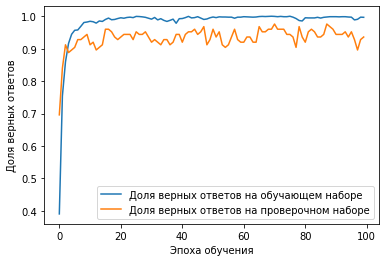

In [26]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(hist_model_ms.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(hist_model_ms.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

### Подсчитываем, сколько у нас на похожих на другие ошибок, и оценим их количество. Выводим примеры наиболее часто встречающихся ошибок.

In [27]:
Y_val_pr_class = np.argmax(model_ms.predict(X_val), axis=1) # сделали массив предсказанных значений
Y_val_class1 = np.expand_dims(Y_val_class, axis = 1) # изменили размер, чтобы объединить столбцы
Y_val_pr_class1 = np.expand_dims(Y_val_pr_class, axis = 1)
comp_arr = np.concatenate((Y_val_class1, Y_val_pr_class1), axis=1) # объединили в один массив истинные и предсказанные значения
comp_arr.shape

(125, 2)

In [28]:
# находим уникальные строки и частоту их появления в массиве
uniq_arr, uniq_cnt = np.unique(comp_arr, axis=0, return_counts=True)
print(uniq_arr.shape) 
print(uniq_cnt.shape) 
# сортируем массив по частоте встречи:
uniq_cnt = np.expand_dims(uniq_cnt, axis = 1)
uniq_all = np.concatenate((uniq_arr, uniq_cnt), axis=1)
uniq_all = uniq_all[uniq_all[:,2].argsort()]
# выводим 10 самых частых ошибок, учитываем, что самые частые 10 в массиве - это правильные ответы, убираем их:
errs = uniq_all[-20:-10,:]
errs

(18, 2)
(18,)


array([[0., 3., 1.],
       [1., 5., 1.],
       [1., 9., 1.],
       [3., 2., 1.],
       [8., 6., 1.],
       [9., 1., 1.],
       [5., 0., 1.],
       [6., 3., 1.]])

###Делаем предсказания моделью

In [29]:
y_pred = model_ms.predict(X_test)
y = []
for i in range(0,len(y_pred)):
    prob = y.append(np.argmax(list(y_pred[i])))

###Переводим ответ в правильный формат, отсылаем для подсчёта рейтинга

In [30]:
submission = pd.DataFrame({"Id":range(1,len(y_pred)+1),"Label":y})
submission.head()

,Id,Label
0,1,9
1,2,4
2,3,0
3,4,5
4,5,7


In [31]:
submission = submission.to_csv('./submission.csv', sep=',', index=False, header=True)

In [32]:
!kaggle competitions submit -c udt-3-audio -f submission.csv -m "Message"

100% 1.37k/1.37k [00:05<00:00, 265B/s]
Successfully submitted to Университет Цифровых Технологий платформа 3

###Смотрим результаты рекордов, ищем себя в таблице:

https://www.kaggle.com/c/udt-3-audio/leaderboard

# Литература

1. http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html
2. https://blog.csdn.net/zzc15806/article/details/79603994
3. https://xakep.ru/2019/09/03/voice-recognition/
4. http://zabaykin.ru/?p=705
5. https://habr.com/ru/company/skillfactory/blog/536834/
6. https://pythonru.com/biblioteki/librosa
7. https://librosa.org/doc/latest/index.html
8. https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB_(%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F)
9. https://nuancesprog.ru/p/6713/
10. https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%86%D0%B8%D0%B1%D0%B5%D0%BB#:~:text=%D0%94%D0%B5%D1%86%D0%B8%D0%B1%D0%B5%CC%81%D0%BB%20
11. https://evgenykondratev.ru/posts/5
12. http://yaafe.sourceforge.net/features.html
13. https://aubio.org/
14. https://wiki.python.org/moin/PythonInMusic
15. https://proglib.io/p/python-music-classifier
16. http://marsyas.info/downloads/datasets.html
17. https://robotics.bstu.by/mwiki/images/c/ca/PopularCepstral.pdf
18. https://habr.com/ru/post/140828/
19. https://alphacephei.com/ru/lecture1.pdf

